# Shock jump conditions

In [1]:
from sympy import *
init_printing(use_unicode=True)

The Euler equations in 1D are:

$\partial_t \vec{U} + \partial_x \vec{F}(\vec{U}) = 0$,

where $\vec{U} = [\rho, u, P]$.

Using the weak form of the Euler equations, and assuming a steady state on the left state $U_L$ and right side $U_R$ of the shock, we can obtain a jump discontinuity solution:

$u_s (\vec{U}_L - \vec{U}_R) = {\vec{F}(\vec{U}_L) - \vec{F}(\vec{U}_R)}$

where $u_s$ is the speed that the discontinuity travels (i.e., the shock speed).

*A crucial simplification is obtained by working in the shock tube frame, where (by definition) $u_R = 0$.*

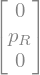

In [2]:
rho_R = Symbol('rho_R')
u_R = 0
p_R = Symbol('p_R')
gamma = Symbol('gamma')
e_R = p_R / (rho_R * (gamma - 1))
E_R = rho_R * (e_R + u_R**2 / 2)
U_R = Matrix([rho_R, rho_R*u_R, E_R])

F_R = Matrix([rho_R*u_R,
        rho_R*u_R**2 + p_R,
        (E_R + p_R)*u_R])
F_R

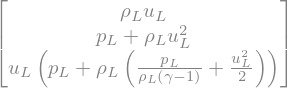

In [3]:
rho_L = Symbol('rho_L')
M = Symbol('M')
u_L = Symbol('u_L')
p_L = Symbol('p_L')
e_L = p_L / (rho_L * (gamma - 1))
E_L = rho_L * (e_L + u_L**2 / 2)
U_L = Matrix([rho_L, rho_L*u_L, E_L])

F_L = Matrix([rho_L*u_L,
        rho_L*u_L**2 + p_L,
        (E_L + p_L)*u_L])
F_L

Now, we want to obtain the left (post-shock) state $U_L$ in terms of the pre-shock state $U_R$ and the Mach number $\mathcal{M}$, which is defined as $\mathcal{M} = u_s / c_R$.

In [4]:
M = Symbol('M')
c_R = sqrt(gamma * p_R / rho_R)
u_s = M * c_R

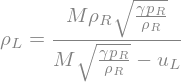

In [5]:
rho_L_sol1 = solveset(Eq(u_s * (U_L[0] - U_R[0]), F_L[0] - F_R[0]), rho_L).args[0]
Eq(rho_L, rho_L_sol1)

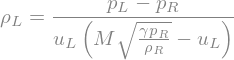

In [6]:
rho_L_sol2 = solveset(Eq(u_s * (U_L[1] - U_R[1]), F_L[1] - F_R[1]), rho_L).args[0]
Eq(rho_L, rho_L_sol2)

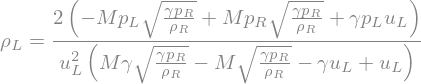

In [7]:
rho_L_sol3 = solveset(Eq(u_s * (U_L[2] - U_R[2]), F_L[2] - F_R[2]), rho_L).args[0]
Eq(rho_L, rho_L_sol3)

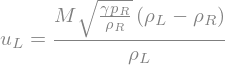

In [8]:
u_L_sol1 = solveset(Eq(u_s * (U_L[0] - U_R[0]), F_L[0] - F_R[0]), u_L).args[0]
Eq(u_L, u_L_sol1)

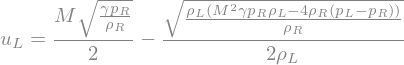

In [9]:
u_L_sol2 = solveset(Eq(u_s * (U_L[1] - U_R[1]), F_L[1] - F_R[1]), u_L).args[0]
Eq(u_L, u_L_sol2)

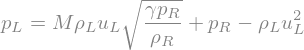

In [10]:
p_L_sol1 = solveset(Eq(u_s * (U_L[1] - U_R[1]), F_L[1] - F_R[1]), p_L).args[0]
Eq(p_L, p_L_sol1)


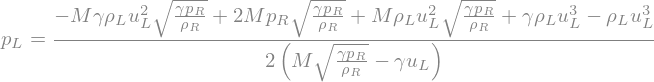

In [11]:
p_L_sol2 = solveset(Eq(u_s * (U_L[2] - U_R[2]), F_L[2] - F_R[2]), p_L).args[0]
Eq(p_L, p_L_sol2)


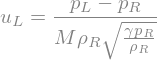

In [12]:
# write u_L in terms of U_R and p_L
u_L_sol_new1 = solveset(Eq(rho_L_sol1, rho_L_sol2), u_L).args[0].args[0]
Eq(u_L, u_L_sol_new1)

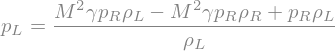

In [13]:
# write p_L in terms of U_R and rho_L
p_L_sol_new1 = solveset(Eq(u_L_sol1, u_L_sol2), p_L).args[2].args[0]
Eq(p_L, p_L_sol_new1)


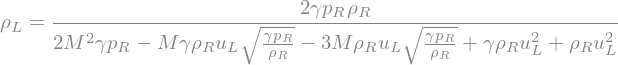

In [14]:
# write rho_L in terms of U_R and u_L
rho_L_sol_new1 = solveset(Eq(p_L_sol1, p_L_sol2), rho_L).args[0]
Eq(rho_L, rho_L_sol_new1)

We finally obtain:

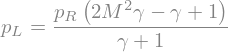

In [15]:
# substitute everything
p_L_sol_final = simplify(solveset(Eq(p_L, p_L_sol_new1.subs(rho_L, rho_L_sol_new1).subs(u_L, u_L_sol_new1)), p_L).args[0])
p_L_lambda = lambdify([M, p_R, gamma], p_L_sol_final)
Eq(p_L, p_L_sol_final)

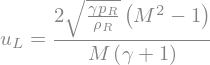

In [16]:
# back substitute
u_L_sol_final = simplify(u_L_sol_new1.subs(p_L, p_L_sol_final))
u_L_lambda = lambdify([M, rho_R, p_R, gamma], u_L_sol_final)
Eq(u_L, u_L_sol_final)

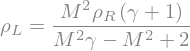

In [17]:
# back substitute
rho_L_sol_final = simplify(rho_L_sol_new1.subs(u_L, u_L_sol_final))
rho_L_lambda = lambdify([M, rho_R, gamma], rho_L_sol_final)
Eq(rho_L, rho_L_sol_final)

In [65]:
## cxxcode
vars = ['rho_L', 'u_L', 'P_L', 'v_shock']
exprs = [rho_L_sol_final, u_L_sol_final, p_L_sol_final, u_s]

optim_exprs = cse(exprs)
expr1 = optim_exprs[0]
expr2 = optim_exprs[1]
for var, expr in expr1:
    print("const Real " + cxxcode(expr, assign_to=var))
for var, expr in zip(vars, expr2):
    print("const Real " + cxxcode(expr, assign_to=var))

const Real x0 = std::pow(M, 2);
const Real x1 = gamma + 1;
const Real x2 = gamma*x0;
const Real x3 = 1.0/x1;
const Real x4 = std::sqrt(gamma*p_R/rho_R);
const Real rho_L = rho_R*x0*x1/(-x0 + x2 + 2);
const Real u_L = 2*x3*x4*(x0 - 1)/M;
const Real P_L = p_R*x3*(-gamma + 2*x2 + 1);
const Real v_shock = M*x4;


### Converting between parameterizations

We want convert between (pre-shock, right-side) background density $\rho_R$, background pressure $p_R$ and wind velocity $v_{\text{wind}}$ and Mach number $\mathcal{M}$.

That is:

$\rho_{bg} = \rho_{R}$,

$p_{bg} = p_R$,

and

$v_{\text{wind}} = u_L$.

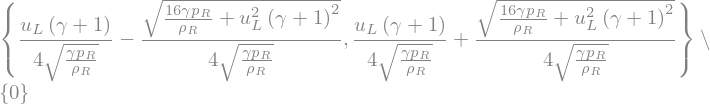

In [18]:
v_wind = Symbol(r'v_{\text{wind}}')
rho_bg = Symbol(r'\rho_{bg}')
p_bg = Symbol(r'p_{bg}')
Mach_solve = solveset(Eq(u_L, u_L_sol_final), M)
Mach_solve

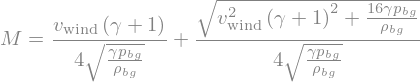

In [19]:
# use positive root (only physical solution)
Mach_sol = Mach_solve.args[0].args[1].subs(u_L, v_wind).subs(rho_R, rho_bg).subs(p_R, p_bg)
compute_mach_number = lambdify([v_wind, rho_bg, p_bg, gamma], Mach_sol)
Eq(M, Mach_sol)

In [28]:
# numerical example

import numpy as np
mH = 1.673533e-24 # H mass (g)
kB = 1.380649e-16 # Boltzmann constant (cgs)
gamma_bg = 5./3.  # assume gamma is constant

v_wind_kms = 200. # km/s
nH_bg = 1.0e-3 # cm^-3
rho_bg = nH_bg * mH # mu = 1 for OOM estimate
P_bg = 1.0e4 # K cm^-3

# compute Mach number of shock
Mach_shock = compute_mach_number(v_wind_kms * 1.0e5, nH_bg * mH, P_bg * kB, 5./3.)
Eq(M, Mach_shock)

In [24]:
# compute post-shock fluid velocity in km/s
Eq(u_L, u_L_lambda(Mach_shock, nH_bg * mH, P_bg * kB, 5./3.) / 1.0e5)

In [26]:
# compute shock velocity in km/s
u_s_lambda = lambdify([M, rho_R, p_R, gamma], u_s)
Eq(Symbol('u_s'), u_s_lambda(Mach_shock, nH_bg * mH, P_bg * kB, 5./3.) / 1.0e5)